**MDCT Image Compression**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Analyze a single image (y/n): y
Enter the path to the image: /content/drive/MyDrive/VC_project/6.tif
Enter the block size (even): 16
Enter the number of coefficients: 256
Is the image color (y/n): n
Enter the output path for the compressed image: /content/drive/MyDrive/VC_project/MDCT_RESULTSghamming


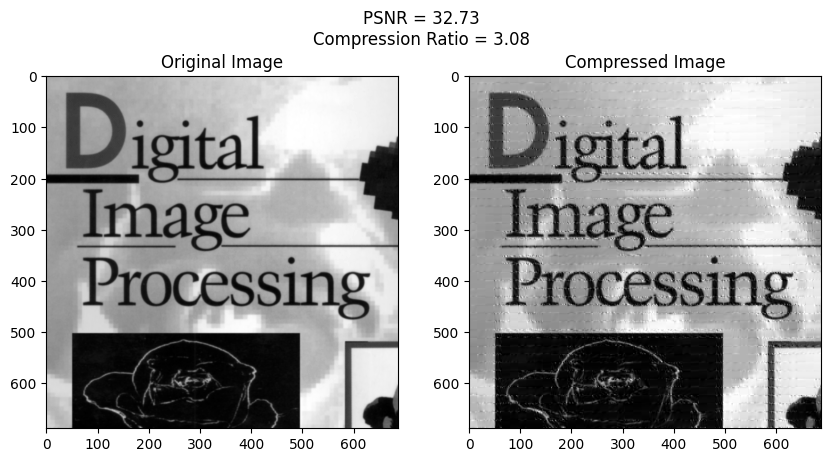

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.fftpack import dct, idct
from scipy.signal import get_window

# Define the quantization matrix used for compression
quant_matrix = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ],
    dtype=np.float32,
)

# Function to calculate PSNR between two images
def compute_psnr(image1: np.ndarray, image2: np.ndarray) -> float:
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * np.log10(255 / np.sqrt(mse))
    return psnr

# Function to calculate the number of elements in a block
def count_elements(blocks: list[np.ndarray]) -> int:
    total_elements = 0
    for block in blocks:
        total_elements += np.trim_zeros(block, "b").size
    return total_elements

# Function to compute total number of elements in blocks
def total_elements_count(
    blocks: list[np.ndarray] | tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray]],
    is_color: bool,
) -> int:
    total = 0
    if is_color:
        total = count_elements(blocks[0]) + count_elements(blocks[1]) + count_elements(blocks[2])
    else:
        total = count_elements(blocks)
    return total

# Zigzag scan of a block
def zigzag_transform(block: np.ndarray) -> np.ndarray:
    size = block.shape[0]
    return np.concatenate(
        [np.diagonal(block[::-1, :], i)[:: (2 * (i % 2) - 1)] for i in range(1 - size, size)]
    )

# Inverse zigzag scan
def inverse_zigzag(scan: np.ndarray, size: int) -> np.ndarray:
    block = np.zeros((size, size), dtype=np.float32)
    x, y = 0, 0
    for num in scan:
        block[x, y] = num
        if (x + y) % 2 == 0:
            if y == size - 1:
                x += 1
            elif x == 0:
                y += 1
            else:
                x -= 1
                y += 1
        else:
            if x == size - 1:
                y += 1
            elif y == 0:
                x += 1
            else:
                x += 1
                y -= 1
    return block

# Modified Discrete Cosine Transform
def mdct_transform(signal):
    length = len(signal)
    window = get_window('hamming', length)
    windowed_signal = signal * window
    transformed_signal = dct(windowed_signal, type=2, norm='ortho')
    return transformed_signal

def inverse_mdct(transformed_signal):
    length = len(transformed_signal)
    windowed_signal = idct(transformed_signal, type=2, norm='ortho')
    window = get_window('hamming', length)
    epsilon = 1e-8
    original_signal = windowed_signal / (window + epsilon)
    return original_signal

# Encode grayscale image into JPEG
def encode_grayscale(
    image: np.ndarray, block_size: int, coefficients: int
) -> list[np.ndarray]:
    height, width = image.shape
    padded_height = height + (block_size - height % block_size) % block_size
    padded_width = width + (block_size - width % block_size) % block_size
    padded_image = np.zeros((padded_height, padded_width), dtype=np.uint8)
    padded_image[:height, :width] = image

    padded_image = padded_image.astype(np.float32) - 128

    blocks = [
        padded_image[i : i + block_size, j : j + block_size]
        for i in range(0, padded_height, block_size)
        for j in range(0, padded_width, block_size)
    ]

    mdct_blocks = [mdct_transform(block.flatten()).reshape(block_size, block_size) for block in blocks]

    resized_quant_matrix = cv2.resize(quant_matrix, (block_size, block_size), cv2.INTER_CUBIC)

    quantized_blocks = [
        np.round(block / resized_quant_matrix).astype(np.int32)
        for block in mdct_blocks
    ]

    zigzag_blocks = [zigzag_transform(block.reshape(block_size, block_size)) for block in quantized_blocks]

    first_coefficients = [block[:coefficients] for block in zigzag_blocks]

    return first_coefficients

# Decode JPEG to grayscale image
def decode_grayscale(
    encoded_blocks: list[np.ndarray], original_img: np.ndarray, block_size: int
) -> np.ndarray:
    height, width = original_img.shape
    padded_height = height + (block_size - height % block_size) % block_size
    padded_width = width + (block_size - width % block_size) % block_size

    resized_quant_matrix = cv2.resize(quant_matrix, (block_size, block_size), cv2.INTER_CUBIC)

    inverse_zigzag_blocks = [inverse_zigzag(block, block_size) for block in encoded_blocks]

    dequantized_blocks = [block * resized_quant_matrix for block in inverse_zigzag_blocks]

    imdct_blocks = [inverse_mdct(block.flatten()).reshape(block_size, block_size) for block in dequantized_blocks]

    compressed_image = np.zeros((padded_height, padded_width), dtype=np.float32)
    block_index = 0
    for i in range(0, padded_height, block_size):
        for j in range(0, padded_width, block_size):
            compressed_image[i : i + block_size, j : j + block_size] = imdct_blocks[block_index].reshape(block_size, block_size)
            block_index += 1

    compressed_image += 128
    compressed_image = np.clip(compressed_image, 0, 255)
    return compressed_image[:height, :width].astype(np.uint8)

# Encode color image into JPEG
def encode_color(
    image: np.ndarray, block_size: int, coefficients: int
) -> tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray]]:
    blue_channel, green_channel, red_channel = cv2.split(image)

    return (
        encode_grayscale(blue_channel, block_size, coefficients),
        encode_grayscale(green_channel, block_size, coefficients),
        encode_grayscale(red_channel, block_size, coefficients),
    )

# Decode JPEG to color image
def decode_color(
    encoded_blocks: tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray]],
    original_img: np.ndarray, block_size: int
) -> np.ndarray:
    blue_channel = decode_grayscale(encoded_blocks[0], original_img[:, :, 0], block_size)
    green_channel = decode_grayscale(encoded_blocks[1], original_img[:, :, 1], block_size)
    red_channel = decode_grayscale(encoded_blocks[2], original_img[:, :, 2], block_size)

    return cv2.merge((blue_channel, green_channel, red_channel))

# JPEG encoder function
def jpeg_encode(
    image_path: str, block_size: int, coefficients: int, is_color: bool
) -> list[np.ndarray] | tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray]]:
    if is_color:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        return encode_color(image, block_size, coefficients)
    else:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        return encode_grayscale(image, block_size, coefficients)

# JPEG decoder function
def jpeg_decode(
    encoded_blocks: list[np.ndarray] | tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray]],
    image_path: str, block_size: int, is_color: bool
) -> np.ndarray:
    if is_color:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        return decode_color(encoded_blocks, image, block_size)
    else:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        return decode_grayscale(encoded_blocks, image, block_size)

def process_image(
    image_path: str, block_size: int, coefficients: int, is_color: bool
) -> tuple[np.ndarray, np.ndarray, float, float, list[np.ndarray] | tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray]], bool]:
    original_img = cv2.imread(image_path, cv2.IMREAD_COLOR if is_color else cv2.IMREAD_GRAYSCALE)

    encoded_img = jpeg_encode(image_path, block_size, coefficients, is_color)
    compressed_img = jpeg_decode(encoded_img, image_path, block_size, is_color)

    psnr_value = compute_psnr(original_img, compressed_img)

    total_elements = total_elements_count(encoded_img, is_color)
    if total_elements == 0:
        compression_ratio = 0
    else:
        compression_ratio = original_img.size / total_elements

    return original_img, compressed_img, psnr_value, compression_ratio, encoded_img, is_color

def display_images(
    original_img: np.ndarray, compressed_img: np.ndarray, psnr: float, compression_ratio: float,
    encoded_img: list[np.ndarray] | tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray]], is_color: bool
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"PSNR = {psnr:.2f}\nCompression Ratio = {compression_ratio:.2f}")

    with open("encoded_image.txt", "w") as f:
        if is_color:
            axs[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
            axs[1].imshow(cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB))
            for row in zip(*encoded_img):
                for element in row:
                    f.write(str(element) + " ")
                f.write("\n")
        else:
            axs[0].imshow(original_img, cmap="gray")
            axs[1].imshow(compressed_img, cmap="gray")
            for row in encoded_img:
                for element in row:
                    f.write(str(element) + " ")
                f.write("\n")

    axs[0].set_title("Original Image")
    axs[1].set_title("Compressed Image")
    plt.show()

def generate_graph(
    img_dir_path: str, is_color: bool
):
    psnr_values = []
    compression_ratios = []
    for coefficients in [1, 3, 6, 10, 15, 28]:
        psnr_list = []
        compression_ratio_list = []
        for img_file in os.listdir(img_dir_path):
            img_path = os.path.join(img_dir_path, img_file)
            _, _, psnr, compression_ratio, _, _ = process_image(img_path, 8, coefficients, is_color)
            psnr_list.append(psnr)
            compression_ratio_list.append(compression_ratio)
        psnr_values.append(np.mean(psnr_list))
        compression_ratios.append(np.mean(np.array(compression_ratio_list)[~np.isnan(compression_ratio_list)]))

    plt.plot(compression_ratios, psnr_values, "o")
    plt.xlabel("Compression Ratio")
    plt.ylabel("PSNR")
    plt.title("PSNR vs Compression Ratio")
    plt.show()

def save_compressed_image(compressed_img, output_path):
    """Save the compressed image to a specified output path."""
    cv2.imwrite(output_path + ".jpg", compressed_img)

if __name__ == "__main__":
    if input("Analyze a single image (y/n): ") == "y":
        img_path = input("Enter the path to the image: ")
        block_size = int(input("Enter the block size (even): "))
        num_coefficients = int(input("Enter the number of coefficients: "))
        color = input("Is the image color (y/n): ") == "y"
        output_path = input("Enter the output path for the compressed image: ")
        original_img, compressed_img, psnr, compression_ratio, encoded_img, is_color = process_image(
            img_path, block_size, num_coefficients, color
        )
        display_images(original_img, compressed_img, psnr, compression_ratio, encoded_img, is_color)
        save_compressed_image(compressed_img, output_path)
    elif input("Analyze all images in a folder (y/n): ") == "y":
        img_dir_path = input("Enter the path to the images folder: ")
        is_color = input("Are the images color (y/n): ") == "y"
        generate_graph(img_dir_path, is_color)

**Running Test Function Again For Colour Image**

Analyze a single image (y/n): y
Enter the path to the image: /content/drive/MyDrive/VC_project/4.png
Enter the block size (even): 16
Enter the number of coefficients: 256
Is the image color (y/n): y
Enter the output path for the compressed image: /content/drive/MyDrive/VC_project/MDCT_RESULTSchamming


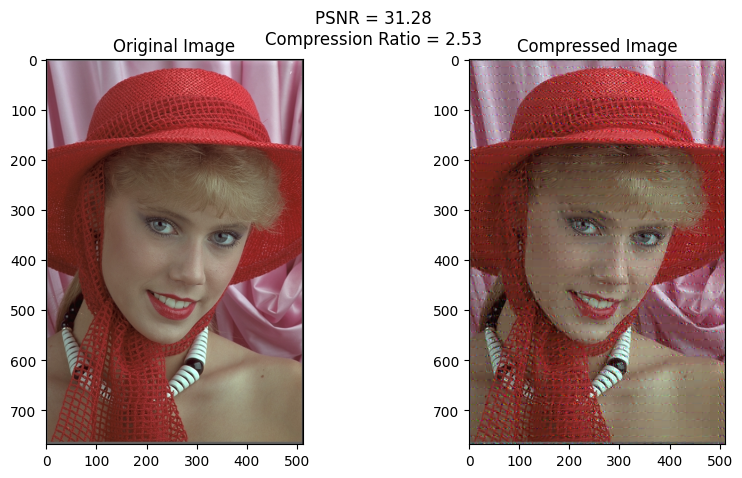

In [14]:
if __name__ == "__main__":
    if input("Analyze a single image (y/n): ") == "y":
        img_path = input("Enter the path to the image: ")
        block_size = int(input("Enter the block size (even): "))
        num_coefficients = int(input("Enter the number of coefficients: "))
        color = input("Is the image color (y/n): ") == "y"
        output_path = input("Enter the output path for the compressed image: ")
        original_img, compressed_img, psnr, compression_ratio, encoded_img, is_color = process_image(
            img_path, block_size, num_coefficients, color
        )
        display_images(original_img, compressed_img, psnr, compression_ratio, encoded_img, is_color)
        save_compressed_image(compressed_img, output_path)
    elif input("Analyze all images in a folder (y/n): ") == "y":
        img_dir_path = input("Enter the path to the images folder: ")
        is_color = input("Are the images color (y/n): ") == "y"
        generate_graph(img_dir_path, is_color)

**DCT Image Compression**

Analyze a single image (y/n): y
Enter the path to the image: /content/drive/MyDrive/VC_project/6.tif
Enter the block size (even): 16
Enter the number of coefficients passed: 256
Is the image color (y/n): n
Enter the output path for the compressed image: /content/drive/MyDrive/VC_project/DCT_RESULTg


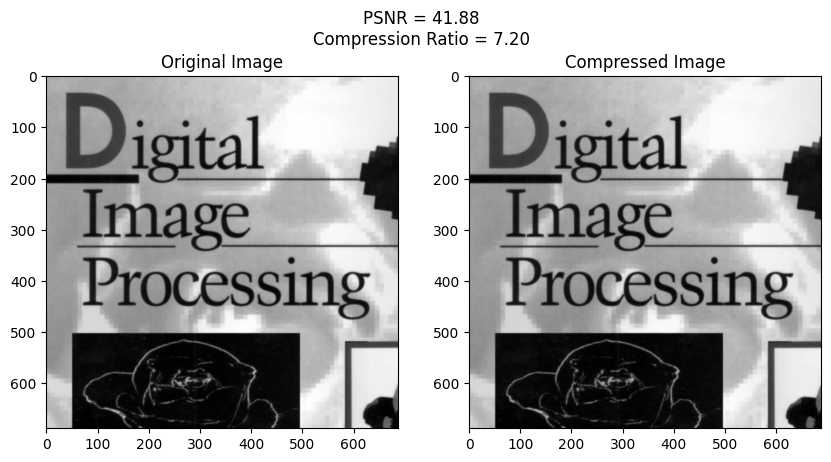

In [4]:
# Import the required modules
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the quantization matrix
quantization_matrix = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ],
    dtype=np.float32,
)


def calculate_psnr(img1: np.ndarray[np.uint8], img2: np.ndarray[np.uint8]) -> float:
    """Calculate PSNR using formula: PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)"""
    mse = np.mean((img1 - img2) ** 2)
    psnr = 20 * np.log10(255 / np.sqrt(mse))
    return psnr


def number_of_elements(blocks: list[np.ndarray[np.int32]]) -> int:
    """Calculates the total number of elements in the grayscale JPEG encoded array"""
    total_elements = 0
    for block in blocks:
        # Trim the trailing zeros from the 1D array
        total_elements += np.trim_zeros(block, "b").size
    return total_elements


def total_number_of_elements(
    blocks: list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    color: bool,
) -> int:
    """
    Calculates the total number of elements for both color and grayscale JPEG encoded arrays
    This is a utility function that will be used to calculate the compression ratio
    """
    total_elements = 0
    if color:
        # Add the number of elements for each color channel
        total_elements = (
            number_of_elements(blocks[0])
            + number_of_elements(blocks[1])
            + number_of_elements(blocks[2])
        )
    else:
        total_elements = number_of_elements(blocks)
    return total_elements


def zigzag_scan(block: np.ndarray[np.int32]) -> np.ndarray[np.int32]:
    """
    Scans a block in zigzag order and return a 1D array
    Each block is assumed to be a square matrix
    """
    block_size = block.shape[0]
    zigzag_arr = np.concatenate(
        [
            np.diagonal(block[::-1, :], i)[:: (2 * (i % 2) - 1)]
            for i in range(1 - block_size, block_size)
        ]
    )
    return zigzag_arr


def zigzag_unscan(
    zigzag_arr: np.ndarray[np.int32], block_size: int
) -> np.ndarray[np.float32]:
    """Unscans a 1D array in zigzag order and return a 2D array"""
    # Create an empty 2D array to store the unscanned values
    block = np.zeros((block_size, block_size), dtype=np.float32)
    x, y = 0, 0
    for num in zigzag_arr:
        # Set the current value in the corresponding coordinate of the 2D array
        block[x, y] = num

        # Determine the direction to move based on the current position
        # if the sum of the coordinates is even
        if (x + y) % 2 == 0:
            # if at the last column, move down one row
            if y == block_size - 1:
                x += 1
            # if at the first row, move right one column
            elif x == 0:
                y += 1
            # otherwise move up one row and right one column
            else:
                x -= 1
                y += 1
        # if the sum of the coordinates is odd
        else:
            # if at the last row, move right one column
            if x == block_size - 1:
                y += 1
            # if at the first column, move down one row
            elif y == 0:
                x += 1
            # otherwise move down one row and left one column
            else:
                x += 1
                y -= 1

    # return the 2D array with the unscanned values
    return block


def grayscale_jpeg_encoder(
    img: np.ndarray[np.uint8], block_size: int, num_coefficients: int
) -> list[np.ndarray[np.int32]]:
    """
    Encodes a grayscale image using JPEG compression
    Returns a list of 1D arrays containing the first `num_coefficients`
    coefficients after performing zigzag scanning on each quantized block
    This is the JPEG encoded array
    """
    # Pad the image to make it divisible by the block size
    height, width = img.shape
    padded_height = height + (block_size - height % block_size) % block_size
    padded_width = width + (block_size - width % block_size) % block_size
    padded_img = np.zeros((padded_height, padded_width), dtype=np.uint8)
    padded_img[:height, :width] = img

    # Subtract 128 from the image
    padded_img = padded_img.astype(np.float32) - 128

    # Split the image into blocks of the given size
    blocks = [
        padded_img[i : i + block_size, j : j + block_size]
        for i in range(0, padded_height, block_size)
        for j in range(0, padded_width, block_size)
    ]

    # Apply the Discrete Cosine Transform (DCT) to each block
    dct_blocks = [cv.dct(block) for block in blocks]

    # Resize the quantization matrix to match the block size
    resized_quantization_matrix = cv.resize(
        quantization_matrix, (block_size, block_size), cv.INTER_CUBIC
    )

    # Quantize each DCT coefficient by dividing with the resized quantization matrix
    quantized_blocks = [
        np.round(block / resized_quantization_matrix).astype(np.int32)
        for block in dct_blocks
    ]

    # Perform zigzag scanning on each quantized block
    zigzag_scanned_blocks = [zigzag_scan(block) for block in quantized_blocks]

    # Retain only the first `num_coefficients` coefficients in each block
    first_num_coefficients = [
        block[:num_coefficients] for block in zigzag_scanned_blocks
    ]

    return first_num_coefficients


def grayscale_jpeg_decoder(
    blocks: list[np.ndarray[np.int32]], img: np.ndarray[np.uint8], block_size: int
) -> np.ndarray[np.uint8]:
    """
    Decodes a grayscale image using JPEG compression from the JPEG encoded array
    Returns a 2D array containing the compressed image
    """
    # Calculated the padded height and width of the image
    height, width = img.shape
    padded_height = height + (block_size - height % block_size) % block_size
    padded_width = width + (block_size - width % block_size) % block_size

    # Resize the quantization matrix to match the block size
    resized_quantization_matrix = cv.resize(
        quantization_matrix, (block_size, block_size), cv.INTER_CUBIC
    )

    # Unscan the zigzag scanned blocks to get the quantized blocks
    zigzag_unscanned_blocks = [zigzag_unscan(block, block_size) for block in blocks]

    # Dequantize the quantized blocks using the resized quantization matrix
    dequantized_blocks = [
        block * resized_quantization_matrix for block in zigzag_unscanned_blocks
    ]

    # Apply the Inverse Discrete Cosine Transform (IDCT) to each dequantized block
    idct_blocks = [cv.idct(block) for block in dequantized_blocks]

    # Reconstruct the compressed image from the IDCT blocks
    compressed_img = np.zeros((padded_height, padded_width), dtype=np.float32)
    block_index = 0
    for i in range(0, padded_height, block_size):
        for j in range(0, padded_width, block_size):
            compressed_img[i : i + block_size, j : j + block_size] = idct_blocks[
                block_index
            ]
            block_index += 1

    compressed_img += 128

    # Crop the image back to its original size
    compressed_img = np.clip(compressed_img, 0, 255)
    return compressed_img[:height, :width].astype(np.uint8)


def color_jpeg_encoder(
    img: np.ndarray[np.uint8], block_size: int, num_coefficients: int
) -> tuple[
    list[np.ndarray[np.int32]], list[np.ndarray[np.int32]], list[np.ndarray[np.int32]]
]:
    """
    Encodes a color image using JPEG compression
    Returns a tuple of 3 lists, each containing
    1D arrays containing the first `num_coefficients`
    coefficients after performing zigzag scanning on each quantized block
    This is the JPEG encoded array
    The three lists correspond to the blue, green, and red channels respectively
    """
    # Split the image into blue, green and red channels
    blue_channel, green_channel, red_channel = cv.split(img)

    # Encode each channel using grayscale_jpeg_encoder
    return (
        grayscale_jpeg_encoder(blue_channel, block_size, num_coefficients),
        grayscale_jpeg_encoder(green_channel, block_size, num_coefficients),
        grayscale_jpeg_encoder(red_channel, block_size, num_coefficients),
    )


def color_jpeg_decoder(
    blocks: tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    img: np.ndarray[np.uint8],
    block_size: int,
) -> np.ndarray[np.uint8]:
    """
    Decodes a JPEG encoded color image
    Returns a 3D array containing the compressed image
    """
    # Split the grayscale image into its color channels
    blue_channel, green_channel, red_channel = cv.split(img)

    # Decode each color channel using grayscale_jpeg_decoder
    blue_channel = grayscale_jpeg_decoder(blocks[0], blue_channel, block_size)
    green_channel = grayscale_jpeg_decoder(blocks[1], green_channel, block_size)
    red_channel = grayscale_jpeg_decoder(blocks[2], red_channel, block_size)

    # Merge the decoded color channels into a color image
    return cv.merge((blue_channel, green_channel, red_channel))


def jpeg_encoder(
    img_path: str,
    block_size: int,
    num_coefficients: int,
    color: bool,
) -> (
    list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ]
):
    """
    Encodes an image using JPEG compression
    Returns the JPEG encoded array
    """
    if color:
        # Load color image and apply color JPEG encoder
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        return color_jpeg_encoder(img, block_size, num_coefficients)
    else:
        # Load grayscale image and apply grayscale JPEG encoder
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        return grayscale_jpeg_encoder(img, block_size, num_coefficients)


def jpeg_decoder(
    blocks: list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    img_path: str,
    block_size: int,
    color: bool,
) -> np.ndarray[np.uint8]:
    """
    Decodes an image using JPEG compression from its JPEG encoded array
    Returns a 2D or 3D array containing the compressed image
    """
    if color:
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        return color_jpeg_decoder(blocks, img, block_size)
    else:
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        return grayscale_jpeg_decoder(blocks, img, block_size)


def analyze_image(
    img_path: str, block_size: int, num_coefficients: int, color: bool
) -> tuple[
    np.ndarray[np.uint8],
    np.ndarray[np.uint8],
    float,
    float,
    list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    bool,
]:
    """
    Analyzes the input image by performing JPEG compression,
    Returns the original and compressed images, and the PSNR and compression ratio
    This can be used to compare the quality of the compressed image
    """
    # Read the image
    img: np.ndarray[np.uint8] = None
    if color:
        img = cv.imread(img_path, cv.IMREAD_COLOR)
    else:
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    # Encode the image using JPEG compression
    encoded_img = jpeg_encoder(img_path, block_size, num_coefficients, color)

    # Decode the image using JPEG compression
    compressed_img = jpeg_decoder(encoded_img, img_path, block_size, color)

    # Calculate the PSNR between the original and compressed images
    psnr = cv.PSNR(img, compressed_img)

    # Calculate the compression ratio
    n2 = total_number_of_elements(encoded_img, color)
    if n2 == 0:
        # In this case, the compression ratio is very high
        # But, we set it to 0 to avoid division by 0 so that our analysis becomes easier
        compression_ratio = 0
    else:
        compression_ratio = img.size / total_number_of_elements(encoded_img, color)

    # Return the original image, compressed image, PSNR, and compression ratio
    # Also return the encoded image and whether the image is color or not
    # The encoded image is returned so that it can be written in a text file
    return (img, compressed_img, psnr, compression_ratio, encoded_img, color)


def plot_images(
    img: np.ndarray[np.uint8],
    compressed_img: np.ndarray[np.uint8],
    psnr: float,
    compression_ratio: float,
    encoded_img: list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    color: bool,
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(
        "PSNR = {:.2f}\nCompression Ratio = {:.2f}".format(psnr, compression_ratio)
    )

    with open("encoded_image.txt", "w") as f:
        if color:
            axs[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            axs[1].imshow(cv.cvtColor(compressed_img, cv.COLOR_BGR2RGB))
            for row in zip(*encoded_img):
                for element in row:
                    f.write(str(element) + " ")
                f.write("\n")

        else:
            axs[0].imshow(img, cmap="gray")
            axs[1].imshow(compressed_img, cmap="gray")
            for row in encoded_img:
                for element in row:
                    f.write(str(element) + " ")
                f.write("\n")

    axs[0].set_title("Original Image")

    axs[1].set_title("Compressed Image")
    plt.show()


def plot_graph(
    img_dir_path: str,
    color: bool,
):
    psnr_list = []
    compression_ratio_list = []
    for num_coefficients in [1, 3, 6, 10, 15, 28]:
        psnr_values = []
        compression_ratio_values = []
        for img_file in os.listdir(img_dir_path):
            img_path = os.path.join(img_dir_path, img_file)
            _, _, psnr, compression_ratio, _, _ = analyze_image(
                img_path, 8, num_coefficients, color
            )
            psnr_values.append(psnr)
            compression_ratio_values.append(compression_ratio)
        psnr_list.append(np.mean(psnr_values))
        compression_ratio_list.append(np.mean(compression_ratio_values))

    plt.plot(compression_ratio_list, psnr_list, "o")
    plt.xlabel("Compression Ratio")
    plt.ylabel("PSNR")
    plt.title("PSNR vs Compression Ratio")
    plt.show()
def save_compressed_image(compressed_img_DCT, output_path):
    """Save the compressed image to a specified output path."""
    output_path = output_path + ".jpg"
    cv.imwrite(output_path, compressed_img_DCT)



# ======================================== Uncomment the following lines to test the code ========================================
# ======================================== You can run both these functions one by one ========================================
if __name__ == "__main__":
    """
    Replace the image path with the path to your image
    plot_images function plots the original and compressed images
    Also, it wries the encoded images to a text file encoded_image.txt
    """
    # plot_images(*analyze_image(img_path="path/to/your/image", block_size=8, num_coefficients=10, color=True))

    """
    Replaces the images folder with the path to your images folder
    plot_graph function plots the PSNR vs Compression Ratio graph
    for all the images in the images folder for different values of num_coefficients
    """
    # plot_graph(img_dir_path="path/to/your/image/folder", color=False)

    if input("Analyze a single image (y/n): ") == "y":
        img_path = input("Enter the path to the image: ")
        block_size = int(input("Enter the block size (even): "))
        num_coefficients = int(input("Enter the number of coefficients passed: "))
        color = input("Is the image color (y/n): ") == "y"
        output_path = input("Enter the output path for the compressed image: ")
        plot_images(*analyze_image(img_path, block_size, num_coefficients, color))
        img, compressed_img_DCT, psnr, compression_ratio, encoded_img, color = analyze_image(img_path, block_size, num_coefficients, color)
        save_compressed_image(compressed_img_DCT, output_path)
    elif input("Analyzes all images in a folder (y/n): ") == "y":
        img_dir_path = input("Enter the path to the images folder: ")
        color = input("Are the images color (y/n): ") == "y"
        plot_graph(img_dir_path, color)

**Running Test Function For Colour Image**

Analyze a single image (y/n): y
Enter the path to the image: /content/drive/MyDrive/VC_project/4.png
Enter the block size (even): 16
Enter the number of coefficients passed: 256
Is the image color (y/n): y
Enter the output path for the compressed image: /content/drive/MyDrive/VC_project/DCT_RESULTc


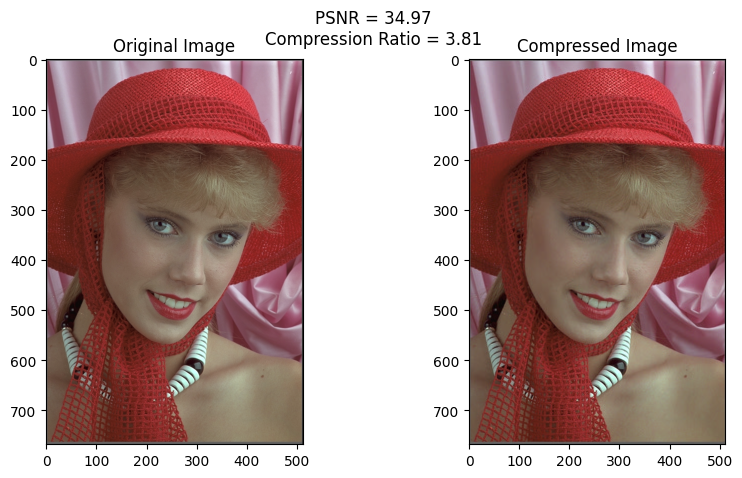

In [5]:
# ======================================== Uncomment the following lines to test the code ========================================
# ======================================== You can run both these functions one by one ========================================
if __name__ == "__main__":
    """
    Replace the image path with the path to your image
    plot_images function plots the original and compressed images
    Also, it wries the encoded images to a text file encoded_image.txt
    """
    # plot_images(*analyze_image(img_path="path/to/your/image", block_size=8, num_coefficients=10, color=True))

    """
    Replaces the images folder with the path to your images folder
    plot_graph function plots the PSNR vs Compression Ratio graph
    for all the images in the images folder for different values of num_coefficients
    """
    # plot_graph(img_dir_path="path/to/your/image/folder", color=False)

    if input("Analyze a single image (y/n): ") == "y":
        img_path = input("Enter the path to the image: ")
        block_size = int(input("Enter the block size (even): "))
        num_coefficients = int(input("Enter the number of coefficients passed: "))
        color = input("Is the image color (y/n): ") == "y"
        output_path = input("Enter the output path for the compressed image: ")
        plot_images(*analyze_image(img_path, block_size, num_coefficients, color))
        img, compressed_img_DCT, psnr, compression_ratio, encoded_img, color = analyze_image(img_path, block_size, num_coefficients, color)
        save_compressed_image(compressed_img_DCT, output_path)
    elif input("Analyzes all images in a folder (y/n): ") == "y":
        img_dir_path = input("Enter the path to the images folder: ")
        color = input("Are the images color (y/n): ") == "y"
        plot_graph(img_dir_path, color)

**Perceptual Similarity**

In [6]:
!git clone https://github.com/richzhang/PerceptualSimilarity.git

Cloning into 'PerceptualSimilarity'...
remote: Enumerating objects: 800, done.
remote: Counting objects: 100% (797/797), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 800 (delta 470), reused 783 (delta 461), pack-reused 3 (from 1)
Receiving objects: 100% (800/800), 8.76 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (470/470), done.


In [7]:
%cd PerceptualSimilarity
!pip install -r requirements.txt

/content/PerceptualSimilarity
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_c

In [8]:
import sys
sys.path.append('/content/PerceptualSimilarity')

**Calculating the similarity between MDCT Compressed Image, DCT Comoressed Image and Original image- GrayScale**

In [15]:
import os
import numpy as np
from PIL import Image
from util import util
from lpips import LPIPS

# Define the paths to the original and compressed images
i_l = '/content/drive/MyDrive/VC_project/6.tif'  # Update as needed
m_c_i_l = '/content/drive/MyDrive/VC_project/MDCT_RESULTSghamming.jpg'  # Update as needed
d_c_i_l= '/content/drive/MyDrive/VC_project/DCT_RESULTg.jpg'  # Update as needed

# Load the images
o_i = Image.open(i_l).convert('RGB')
m_c_i = Image.open(m_c_i_l).convert('RGB')
d_c_i = Image.open(d_c_i_l).convert('RGB')

def get_file_size(file_path):
    """Return the size of the file in bytes."""
    return os.path.getsize(file_path)

def get_image_dimensions(i_l):
    """Return the dimensions (width, height) of the image."""
    with Image.open(i_l) as img:
        return img.size

# Calculate file sizes in bytes
o_s = get_file_size(i_l)
m_c_s = get_file_size(m_c_i_l)
d_c_s = get_file_size(d_c_i_l)

# Calculate compression ratios
mcr = o_s / m_c_s
dcr = o_s / d_c_s

# Calculate bits per pixel for the original image
width, height = get_image_dimensions(i_l)
t_p = width * height
mdct_bpp = (m_c_s * 8) / t_p
dct_bpp = (d_c_s * 8) / t_p

print(f"MDCT Compression Ratio: {mcr}")
print(f"DCT Compression Ratio: {dcr}")
print(f"MDCT Bits Per Pixel: {mdct_bpp}")
print(f"DCT Bits Per Pixel: {dct_bpp}")

# Initialize the LPIPS model
l_m = LPIPS(net='alex')  # Corrected model initialization

# Convert images to tensors using utility functions
o_t = util.im2tensor(np.array(o_i))  # Convert PIL Image to NumPy array before tensor conversion
m_c_t = util.im2tensor(np.array(m_c_i))
d_c_t = util.im2tensor(np.array(d_c_i))

# Compute perceptual similarity using the LPIPS model
mdct_similarity = l_m.forward(o_t, m_c_t)
dct_similarity = l_m.forward(o_t, d_c_t)

print(f"MDCT Perceptual Similarity: {mdct_similarity.item()}")
print(f"DCT  Perceptual Similarity: {dct_similarity.item()}")

MDCT Compression Ratio: 2.7774634789010735
DCT Compression Ratio: 5.132321351854504
MDCT Bits Per Pixel: 2.616988912925906
DCT Bits Per Pixel: 1.416238507301244
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /content/PerceptualSimilarity/lpips/weights/v0.1/alex.pth
MDCT Perceptual Similarity: 0.4458668828010559
DCT  Perceptual Similarity: 0.01662929356098175


**Calculating the similarity between MDCT Compressed Image, DCT Comoressed Image and Original image- Colour Image**

In [16]:
import os
import numpy as np
from PIL import Image
from util import util
from lpips import LPIPS

# Define the paths to the original and compressed images
i_l = '/content/drive/MyDrive/VC_project/4.png'  # Update as needed
m_c_i_l = '/content/drive/MyDrive/VC_project/MDCT_RESULTSchamming.jpg'  # Update as needed
d_c_i_l= '/content/drive/MyDrive/VC_project/DCT_RESULTc.jpg'  # Update as needed

# Load the images
o_i = Image.open(i_l).convert('RGB')
m_c_i = Image.open(m_c_i_l).convert('RGB')
d_c_i = Image.open(d_c_i_l).convert('RGB')

def get_file_size(file_path):
    """Return the size of the file in bytes."""
    return os.path.getsize(file_path)

def get_image_dimensions(i_l):
    """Return the dimensions (width, height) of the image."""
    with Image.open(i_l) as img:
        return img.size

# Calculate file sizes in bytes
o_s = get_file_size(i_l)
m_c_s = get_file_size(m_c_i_l)
d_c_s = get_file_size(d_c_i_l)

# Calculate compression ratios
mcr = o_s / m_c_s
dcr = o_s / d_c_s

# Calculate bits per pixel for the original image
width, height = get_image_dimensions(i_l)
t_p = width * height
mdct_bpp = (m_c_s * 8) / t_p
dct_bpp = (d_c_s * 8) / t_p

print(f"MDCT Compression Ratio: {mcr}")
print(f"DCT Compression Ratio: {dcr}")
print(f"MDCT Bits Per Pixel: {mdct_bpp}")
print(f"DCT Bits Per Pixel: {dct_bpp}")

# Initialize the LPIPS model
l_m = LPIPS(net='alex')  # Corrected model initialization

# Convert images to tensors using utility functions
o_t = util.im2tensor(np.array(o_i))  # Convert PIL Image to NumPy array before tensor conversion
m_c_t = util.im2tensor(np.array(m_c_i))
d_c_t = util.im2tensor(np.array(d_c_i))

# Compute perceptual similarity using the LPIPS model
mdct_similarity = l_m.forward(o_t, m_c_t)
dct_similarity = l_m.forward(o_t, d_c_t)

print(f"MDCT Perceptual Similarity: {mdct_similarity.item()}")
print(f"DCT  Perceptual Similarity: {dct_similarity.item()}")

MDCT Compression Ratio: 3.418525828041874
DCT Compression Ratio: 5.340594523945173
MDCT Bits Per Pixel: 3.7936197916666665
DCT Bits Per Pixel: 2.4283040364583335
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /content/PerceptualSimilarity/lpips/weights/v0.1/alex.pth
MDCT Perceptual Similarity: 0.4168405532836914
DCT  Perceptual Similarity: 0.09168823063373566


# **Result Analysis**
The following are the description of result for Compression Ratio, Bits Per Pixel and Perceptual similarity for coloured as well as grayscale image.

# **Colour Image Results**
Following are the results of colour images
### **Compression Ratio:**
MDCT Compression Ratio: 3.418525828041874

DCT Compression Ratio: 5.340594523945173

The result shows that the DCT outperforms the MDCT in image compression as higher value indicate better compression ratio.

### **Bits Per Pixel:**
MDCT Bits Per Pixel: 3.7936197916666665

DCT Bits Per Pixel: 2.4283040364583335

The result shows that the DCT outperforms the MDCT in compressing the image as lower value indicate better compression of image.

### **Perceptual Similarity:**
MDCT Perceptual Similarity: 0.4168405532836914

DCT  Perceptual Similarity: 0.09168823063373566

The result shows that the DCT outperforms the MDCT in compressing the image as lower value indicate better perceptual similarity.

# **Grayscale Image Results**
Following are the results of colour images
### **Compression Ratio:**
MDCT Compression Ratio: 2.7774634789010735

DCT Compression Ratio: 5.132321351854504

The result shows that the DCT outperforms the MDCT in image compression as higher value indicate better compression ratio.

### **Bits Per Pixel:**
MDCT Bits Per Pixel: 2.616988912925906

DCT Bits Per Pixel: 1.416238507301244

The result shows that the DCT outperforms the MDCT in compressing the image as lower value indicate better compression of image.

### **Perceptual Similarity:**
MDCT Perceptual Similarity: 0.4458668828010559

DCT  Perceptual Similarity: 0.01662929356098175

The result shows that the DCT outperforms the MDCT in compressing the image as lower value indicate better perceptual similarity.



# **Conclusion**
According to data acquired from the asked metric, it's clear that DCT has better image compression than MDCT in respect of compression and perceptual similarity